# CryptoCurrency Portfolio Tracker in Python
## Part 3: Creating a Full-Fledged Application

In [9]:
import pandas as pd
import sqlite3
import os

def get_connection():
    conn = sqlite3.connect('../Application/crypto_portfolio.db')
    return conn

In [ ]:
conn = get_connection()
cursor = conn.cursor()
cursor.execute(f'''
CREATE TABLE IF NOT EXISTS prices (
    symbol TEXT,
    price REAL,
    volume_24h REAL,
    volume_change_24h REAL,
    percent_change_1h REAL,
    percent_change_24h REAL,
    percent_change_7d REAL,
    percent_change_30d REAL,
    percent_change_60d REAL,
    percent_change_90d REAL,
    market_cap REAL,
    market_cap_dominance REAL,
    fully_diluted_market_cap REAL,
    tvl REAL,
    last_updated TEXT
)
''')
conn.commit()
conn.close()

In [10]:
conn = get_connection()
prices = pd.read_sql("SELECT * FROM prices;",con=conn)
display(prices)
conn.close()

,symbol,price,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,tvl,last_updated
0,BTC,66962.942594,3.230571e+10,94.4325,0.034063,-3.479351,-3.022191,9.551532,-4.837972,-7.969870,1.319896e+12,54.1387,1.406222e+12,NaN,2024-06-11T12:44:00.000Z
1,ETH,3531.228023,1.584348e+10,73.5557,-0.002675,-3.902717,-6.096341,20.526184,1.061368,-12.212793,4.242522e+11,17.3970,4.242522e+11,NaN,2024-06-11T12:43:00.000Z
2,FTM,0.651059,1.374001e+08,38.6611,-1.435305,-4.153448,-20.091030,-10.022188,-27.002075,-22.209388,1.825333e+09,0.0749,2.067114e+09,NaN,2024-06-11T12:43:00.000Z
3,DOT,6.314295,2.352532e+08,12.6964,-1.108012,-1.931519,-9.722095,-6.277771,-24.021749,-42.645952,9.079662e+09,0.3723,9.079662e+09,NaN,2024-06-11T12:43:00.000Z
4,SOL,153.725808,2.135551e+09,38.2201,-0.328228,-3.084688,-7.251808,5.888314,-9.639809,0.283473,7.085988e+10,2.9065,8.883197e+10,NaN,2024-06-11T12:43:00.000Z
5,AAVE,87.435294,1.383826e+08,17.2413,-0.520909,-4.558623,-13.140005,4.967836,-24.018875,-40.552192,1.298164e+09,0.0532,1.398965e+09,1.284574e+10,2024-06-11T12:43:00.000Z
6,HEX,0.001348,1.931030e+05,34.5818,-0.262003,-5.202683,-7.627907,-32.384313,-22.589505,-36.074471,2.337817e+08,0.0000,8.541016e+08,NaN,2024-06-11T12:43:00.000Z
7,GALA,0.035437,1.247898e+08,15.1665,-1.096321,-5.174620,-20.605057,-16.066519,-38.398374,-53.036942,1.121528e+09,0.0460,1.193435e+09,NaN,2024-06-11T12:43:00.000Z
8,ILV,81.134453,1.148708e+07,-16.8734,-0.064551,-5.153227,-11.220321,-4.061311,-32.049191,-43.807685,3.574172e+08,0.0146,6.685273e+08,NaN,2024-06-11T12:44:00.000Z
9,AERO,0.884030,2.175945e+07,62.2262,-0.202435,-6.279757,-16.455185,-5.168742,-52.444503,31.103663,4.302050e+08,0.0000,9.613858e+08,NaN,2024-06-11T12:43:00.000Z


### Get Crypto Prices from API

In [6]:
import pandas as pd
import sqlite3
import os
api_key = os.environ.get('CMC_API_KEY')


def get_response_multiple(symbols):
    from requests import Session
    import json
    url = 'https://pro-api.coinmarketcap.com/v2/cryptocurrency/quotes/latest'
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key,
    }
    session = Session()
    session.headers.update(headers)
    parameters = {
        'symbol': ','.join(symbols)
    }
    response = session.get(url, params=parameters)
    return json.loads(response.text)



def clean_response_multiple(symbols):
    data = get_response_multiple(symbols)
    df = pd.DataFrame(
        [{'symbol': symbol, **data['data'][symbol][0]['quote']['USD']} for symbol in symbols]
    )
    return df

In [7]:
df = clean_response_multiple(['BTC','ETH'])

In [8]:
df

,symbol,price,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,tvl,last_updated
0,BTC,67715.421223,2.226929e+10,-17.3671,0.139538,-1.384677,-2.013076,15.496249,3.757425,8.789458,1.334425e+12,52.7119,1.422024e+12,None,2024-06-01T12:57:00.000Z
1,ETH,3795.867127,1.289180e+10,-10.1754,0.240584,-0.758731,1.573154,27.273663,15.042442,10.864338,4.560434e+11,18.0144,4.560434e+11,None,2024-06-01T12:58:00.000Z


In [9]:
for i in df.columns:
    print(type(df[i].iloc[0]))

<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'NoneType'>
<class 'str'>


In [10]:
conn = get_connection()
cursor = conn.cursor()
for _, row in df.iterrows():
        cursor.execute(f'''
        insert into prices (symbol, price, volume_24h, volume_change_24h, percent_change_1h, percent_change_24h, 
                                percent_change_7d, percent_change_30d, percent_change_60d, percent_change_90d, 
                                market_cap, market_cap_dominance, fully_diluted_market_cap, tvl, last_updated)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (row['symbol'], row['price'], row['volume_24h'], row['volume_change_24h'], row['percent_change_1h'],
            row['percent_change_24h'], row['percent_change_7d'], row['percent_change_30d'],
            row['percent_change_60d'], row['percent_change_90d'], row['market_cap'],
            row['market_cap_dominance'], row['fully_diluted_market_cap'], row['tvl'], row['last_updated']))
conn.commit()  
conn.close()

In [11]:
conn = get_connection()
cursor = conn.cursor()
prices = pd.read_sql("select * from prices", con=conn)   
conn.close()
display(prices)

,symbol,price,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,tvl,last_updated
0,BTC,66962.942594,3.230571e+10,94.4325,0.034063,-3.479351,-3.022191,9.551532,-4.837972,-7.969870,1.319896e+12,54.1387,1.406222e+12,NaN,2024-06-11T12:44:00.000Z
1,ETH,3531.228023,1.584348e+10,73.5557,-0.002675,-3.902717,-6.096341,20.526184,1.061368,-12.212793,4.242522e+11,17.3970,4.242522e+11,NaN,2024-06-11T12:43:00.000Z
2,FTM,0.651059,1.374001e+08,38.6611,-1.435305,-4.153448,-20.091030,-10.022188,-27.002075,-22.209388,1.825333e+09,0.0749,2.067114e+09,NaN,2024-06-11T12:43:00.000Z
3,DOT,6.314295,2.352532e+08,12.6964,-1.108012,-1.931519,-9.722095,-6.277771,-24.021749,-42.645952,9.079662e+09,0.3723,9.079662e+09,NaN,2024-06-11T12:43:00.000Z
4,SOL,153.725808,2.135551e+09,38.2201,-0.328228,-3.084688,-7.251808,5.888314,-9.639809,0.283473,7.085988e+10,2.9065,8.883197e+10,NaN,2024-06-11T12:43:00.000Z
5,AAVE,87.435294,1.383826e+08,17.2413,-0.520909,-4.558623,-13.140005,4.967836,-24.018875,-40.552192,1.298164e+09,0.0532,1.398965e+09,1.284574e+10,2024-06-11T12:43:00.000Z
6,HEX,0.001348,1.931030e+05,34.5818,-0.262003,-5.202683,-7.627907,-32.384313,-22.589505,-36.074471,2.337817e+08,0.0000,8.541016e+08,NaN,2024-06-11T12:43:00.000Z
7,GALA,0.035437,1.247898e+08,15.1665,-1.096321,-5.174620,-20.605057,-16.066519,-38.398374,-53.036942,1.121528e+09,0.0460,1.193435e+09,NaN,2024-06-11T12:43:00.000Z
8,ILV,81.134453,1.148708e+07,-16.8734,-0.064551,-5.153227,-11.220321,-4.061311,-32.049191,-43.807685,3.574172e+08,0.0146,6.685273e+08,NaN,2024-06-11T12:44:00.000Z
9,AERO,0.884030,2.175945e+07,62.2262,-0.202435,-6.279757,-16.455185,-5.168742,-52.444503,31.103663,4.302050e+08,0.0000,9.613858e+08,NaN,2024-06-11T12:43:00.000Z


In [3]:
def exec_sql(query):
    conn = get_connection()
    cursor = conn.cursor()
    cursor.execute(query)
    conn.commit()
    conn.close()

In [4]:
# exec_sql('delete from prices')

In [26]:
# conn = get_connection()
# df.to_sql(prices, con=conn, if_exists='replace', index=False)
# conn.close()

In [12]:
def update_prices():
    conn = get_connection()
    cursor = conn.cursor()
    cursor.execute('delete from prices')
    results = cursor.execute("select distinct symbol from portfolio").fetchall()
    coins = [row[0] for row in results]
    df = clean_response_multiple(coins)
    for _, row in df.iterrows():
        cursor.execute(f'''
        insert into prices (symbol, price, volume_24h, volume_change_24h, percent_change_1h, percent_change_24h, 
                                percent_change_7d, percent_change_30d, percent_change_60d, percent_change_90d, 
                                market_cap, market_cap_dominance, fully_diluted_market_cap, tvl, last_updated)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (row['symbol'], row['price'], row['volume_24h'], row['volume_change_24h'], row['percent_change_1h'],
            row['percent_change_24h'], row['percent_change_7d'], row['percent_change_30d'],
            row['percent_change_60d'], row['percent_change_90d'], row['market_cap'],
            row['market_cap_dominance'], row['fully_diluted_market_cap'], row['tvl'], row['last_updated']))
    conn.commit()
    conn.close()
update_prices()

In [13]:
conn = get_connection()
cursor = conn.cursor()
cursor.execute("delete from portfolio where symbol not in ('BTC','ETH','SOL','DOT')")
conn.commit()
conn.close()

In [16]:
conn = get_connection()
dfjoin = pd.read_sql('select portfolio.amount, portfolio.cost, prices.* from portfolio left join prices on portfolio.symbol = prices.symbol', conn)
conn.close()
dfjoin

,amount,cost,symbol,price,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,tvl,last_updated
0,1.75,50000.0,BTC,66931.604321,3.407113e+10,107.1922,0.112547,-3.962004,-3.960254,9.403141,-3.416156,-7.747005,1.319279e+12,54.2117,1.405564e+12,NaN,2024-06-11T15:11:00.000Z
1,25.00,50000.0,ETH,3518.204576,1.636971e+10,82.4363,-0.219621,-4.473077,-6.791961,20.094148,2.276371,-11.173148,4.226875e+11,17.3876,4.226875e+11,NaN,2024-06-11T15:10:00.000Z
2,100.00,10000.0,SOL,151.712246,2.262759e+09,50.5868,-0.125274,-5.581985,-8.471573,4.951323,-9.285051,-1.841559,6.993163e+10,2.8736,8.766831e+10,NaN,2024-06-11T15:10:00.000Z
3,20000.00,10000.0,FTM,0.646683,1.551907e+08,61.8726,1.125601,-5.958342,-20.566897,-9.498472,-25.974668,-19.878769,1.813062e+09,0.0745,2.053218e+09,NaN,2024-06-11T15:10:00.000Z
4,100.00,7500.0,AAVE,86.646846,1.425467e+08,21.2865,-0.277698,-6.244242,-14.085340,3.904630,-22.558575,-39.839384,1.286460e+09,0.0529,1.386350e+09,1.284574e+10,2024-06-11T15:10:00.000Z
5,2500.00,10000.0,DOT,6.279864,2.415708e+08,15.9320,0.436596,-3.721772,-11.667704,-6.728156,-22.827002,-41.327509,9.030152e+09,0.3708,9.030152e+09,NaN,2024-06-11T15:10:00.000Z


### PostProcessing the data

In [15]:
dfjoin.columns

Index(['amount', 'cost', 'symbol', 'price', 'volume_24h', 'volume_change_24h',
       'percent_change_1h', 'percent_change_24h', 'percent_change_7d',
       'percent_change_30d', 'percent_change_60d', 'percent_change_90d',
       'market_cap', 'market_cap_dominance', 'fully_diluted_market_cap', 'tvl',
       'last_updated'],
      dtype='object')

### All Together

In [ ]:
import pandas as pd
import sqlite3
import os
api_key = os.environ.get('CMC_API_KEY')

def get_connection():
    conn = sqlite3.connect('crypto_portfolio.db')
    return conn

def get_response_multiple(symbols):
    from requests import Session
    import json
    url = 'https://pro-api.coinmarketcap.com/v2/cryptocurrency/quotes/latest'
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key,
    }
    session = Session()
    session.headers.update(headers)
    parameters = {
        'symbol': ','.join(symbols)
    }
    response = session.get(url, params=parameters)
    return json.loads(response.text)

def clean_response_multiple(symbols):
    data = get_response_multiple(symbols)
    df = pd.DataFrame(
        [{'symbol': symbol, **data['data'][symbol][0]['quote']['USD']} for symbol in symbols]
    )
    return df

def update_prices():
    conn = get_connection()
    cursor = conn.cursor()
    cursor.execute('delete from prices')
    results = cursor.execute("select distinct symbol from portfolio").fetchall()
    coins = [row[0] for row in results]
    df = clean_response_multiple(coins)
    for _, row in df.iterrows():
        cursor.execute(f'''
        insert into prices (symbol, price, volume_24h, volume_change_24h, percent_change_1h, percent_change_24h, 
                                percent_change_7d, percent_change_30d, percent_change_60d, percent_change_90d, 
                                market_cap, market_cap_dominance, fully_diluted_market_cap, tvl, last_updated)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (row['symbol'], row['price'], row['volume_24h'], row['volume_change_24h'], row['percent_change_1h'],
            row['percent_change_24h'], row['percent_change_7d'], row['percent_change_30d'],
            row['percent_change_60d'], row['percent_change_90d'], row['market_cap'],
            row['market_cap_dominance'], row['fully_diluted_market_cap'], row['tvl'], row['last_updated']))
    conn.commit()
    conn.close()
update_prices()

### Data Visualization

In [17]:
conn = get_connection()
raw_df = pd.read_sql('select portfolio.amount, portfolio.cost, prices.* from portfolio left join prices on portfolio.symbol = prices.symbol', conn)

In [18]:
from datetime import datetime, timedelta
last_update_old = datetime.strptime(min(raw_df['last_updated']), '%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d %I:%M %p')
last_update_new = (datetime.strptime(min(raw_df['last_updated']), '%Y-%m-%dT%H:%M:%S.%fZ') - timedelta(hours=4)).strftime('%Y-%m-%d %I:%M %p')

print(last_update_old)
print(last_update_new)

2024-06-11 03:10 PM
2024-06-11 11:10 AM


In [19]:
coins = raw_df[['symbol','amount','cost','price','percent_change_24h']].copy()
coins['avg_price'] = coins['cost'] / coins['amount']
coins['value'] = coins['amount']*coins['price']
coins['net'] = coins['value'] - coins['cost']
coins['%'] = (coins['net'] / coins['cost'])*100
coins['X'] = coins['value'] / coins['cost']
coins['24h_value'] = coins['value']/((coins['percent_change_24h']/100)+1)
coins['24h_net'] = coins['value'] - coins['24h_value']

In [45]:
coins.columns

Index(['symbol', 'amount', 'cost', 'price', 'percent_change_24h', 'avg_price',
       'value', 'net', '%', 'X', '24h_value', '24h_net'],
      dtype='object')

In [78]:
%matplotlib inline

In [20]:
df = coins[['symbol','value']]
df

,symbol,value
0,BTC,117130.307561
1,ETH,87955.114411
2,SOL,15171.224602
3,FTM,12933.655960
4,AAVE,8664.684613
5,DOT,15699.659962


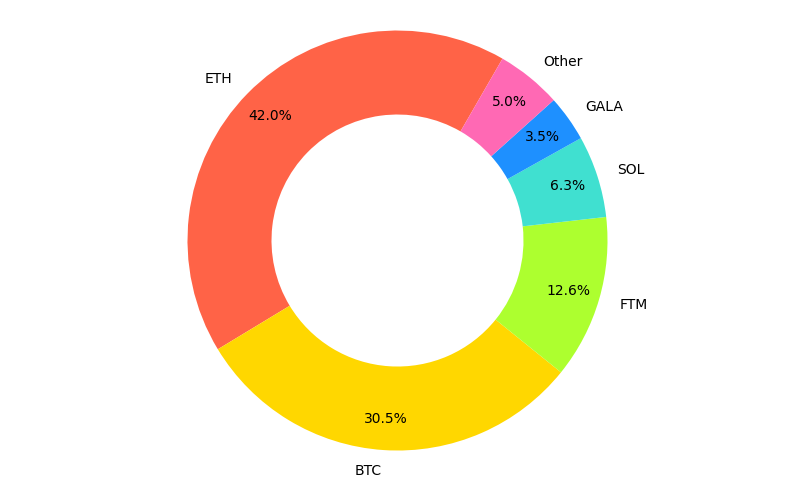

In [115]:
# Ensure the inline backend is used for matplotlib
%matplotlib inline

# def display_pie_chart(data):
#     df = data[['symbol','value']]
#     def group_top_n(data, n=5):
#         data = data.sort_values(by='value', ascending=False).reset_index(drop=True)
#         top_n = data.iloc[:n]
#         other = pd.DataFrame([{
#             'symbol': 'Other',
#             'value': data.iloc[n:]['value'].sum()
#         }])
#         grouped_data = pd.concat([top_n, other], ignore_index=True)
#         return grouped_data
#     grouped_df = group_top_n(df)

def create_pie_chart(data, n):
    data = data.sort_values(by='value', ascending=False).reset_index(drop=True)
    top_n = data.iloc[:n]
    other = pd.DataFrame([{
        'symbol': 'Other',
        'value': data.iloc[n:]['value'].sum()
    }])
    grouped_data = pd.concat([top_n, other], ignore_index=True)

    custom_colors = ['#FF6347', '#FFD700', '#ADFF2F', '#40E0D0', '#1E90FF', '#FF69B4']
    fig, ax = plt.subplots(figsize=(10, 6))
    wedges = ax.pie(
        grouped_data['value'], 
        labels=grouped_data['symbol'], 
        autopct='%1.1f%%', 
        startangle=60,
        colors=custom_colors,
        pctdistance=0.85, 
        labeldistance=1.1, 
        wedgeprops=dict(width=0.4)  
    )

    ax.axis('equal')  
    plt.show()
    
create_pie_chart(coins, 5)


In [87]:
create_pie_chart()

TypeError: create_pie_chart() missing 1 required positional argument: 'data'

In [ ]:
def group_top_n(data, n=5):
    df = data[['symbol','value']]
    data = data.sort_values(by='value', ascending=False).reset_index(drop=True)
    top_n = data.iloc[:n]
    other = pd.DataFrame([{
        'symbol': 'Other',
        'value': data.iloc[n:]['value'].sum()
    }])
    grouped_data = pd.concat([top_n, other], ignore_index=True)
    return grouped_data



def create_pie_chart(data):
    grouped_df = group_top_n(data)
    custom_colors = ['#FF6347', '#FFD700', '#ADFF2F', '#40E0D0', '#1E90FF', '#FF69B4']
    fig, ax = plt.subplots(figsize=(10, 6))
    wedges, texts, autotexts  = ax.pie(
        data['value'], 
        labels=data['symbol'], 
        autopct='%1.1f%%', 
        startangle=60,
        colors=custom_colors,
        pctdistance=0.85,   # Percentage labels inside the slices
        labeldistance=1.1,  # Labels slightly outside the slices
        wedgeprops=dict(width=0.3)  # Adjusts the width of the pie slices
    )
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    for text in texts:
        text.set_fontsize(10)
    ax.axis('equal')  
    return fig
create_pie_chart(grouped_df)